# t-SNE (t-distributed Stochastic Neighbor Embedding)
## Objectif 
L'objectif de la méthode t-sne est de réduire la taille d'un jeu de données pour pouvoir les visualiser en 2D/3D.  
Pour ce faire :  
$
\begin{aligned}
&-\text{Transformer les distances en grande dimension en probabilité} \\
&-\text{Reproduire cette probabilité en dimension 2 ou 3}
\end{aligned}
$

In [25]:
import numpy as np
from scipy.stats import uniform,expon
from sklearn.datasets import load_digits
import pandas as pd
from matplotlib import pyplot as plt
df = load_digits()
data = pd.DataFrame(df.data)
data = data.dropna()
data

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


# Etape 1 - Construire la probabilité 
Pour chaque pair $(x_i,x_j)$ on cherche à calculer une probabilité conditionnelle, on se contentera de : 
$$
p(x_i | x_j) = f(x_i,x_j) = \frac{exp(- \left\|x_k - x_j\right\|_2)}{\sum_{k \neq i} exp(-\left\|x_k - x_i\right\|_2)}
$$
Toute autre fonction de probabilité fonctionne.

In [83]:
from numpy.linalg import norm
import numpy as np

sigma =1

def p(data):
    A = data.values  # si data est un DataFrame pandas, sinon A = data si déjà numpy
    n = A.shape[0]

    # Calcul matrice distances au carré (broadcast numpy)
    diff = A[:, np.newaxis, :] - A[np.newaxis, :, :]  # forme (n, n, d)
    dist_sq = np.sum(diff**2, axis=2)  # forme (n, n)

    # Calcul des probabilités conditionnelles P_{j|i}
    P = np.exp(-dist_sq / (2 * sigma**2))

    np.fill_diagonal(P, 0)

    # Normalisation ligne par ligne
    row_sums = P.sum(axis=1, keepdims=True)
    P = P / row_sums

    # Symétrisation et normalisation finale
    P = (P + P.T) / (2 * n)

    return P



# Etape 2 - Construire la probabilité 
Pour chaque pair $(x_i,x_j)$ on cherche à determiner une probabilité : 
$$
q(x_i | x_j) = g(x_i, x_j) = \frac{\frac{1}{1 + \|x_i - x_j\|_2^2}}{\sum_{k \neq i} \frac{1}{1 + \|x_k - x_i\|_2^2}}
$$

tel que $q$ minimise $KL(p||q)$

In [84]:
def q(i, j, Y):
    diffs = Y - Y[i]                            # (n_samples, 2)
    distances = np.linalg.norm(diffs, axis=1)**2
    distances[i] = np.inf                       # Exclure i
    
    L = np.sum(np.exp(-distances / (2 * sigma_i**2)))  # même sigma_i que dans p
    
    numerator = np.exp(-norm(Y[i] - Y[j])**2 / (2 * sigma_i**2))
    return numerator / L


La divergence de Kullback-Leibler (KL) entre deux distributions de probabilité \(P\) et \(Q\) est définie comme :

$$
\mathrm{KL}(P \| Q) = \sum_i P_i \log \left(\frac{P_i}{Q_i}\right)
$$

Elle mesure la différence entre les distributions \(P\) et \(Q\), et est toujours positive ou nulle.  
Plus la divergence est faible, plus \(Q\) est proche de \(P\).


In [85]:
def KL(Y):
    C = 0
    n = data.shape[0]
    for j in range(n):
        for i in range(n):
            if i != j:
                pij = p(i, j)
                qij = q(i, j, Y)
                # Pour éviter log(0) ou division par 0, on peut ajouter un epsilon
                epsilon = 1e-12
                pij = max(pij, epsilon)
                qij = max(qij, epsilon)
                C += pij * np.log(pij / qij)
    return C


In [86]:
"""n = data.shape[0]
Y_init = np.random.randn(n, 2) * 1e-4
Y_init_flat = Y_init.flatten()

def KL_flat(Y_flat):
    Y = Y_flat.reshape((n, 2))
    return KL(Y)

from scipy.optimize import minimize

res = minimize(KL_flat, Y_init_flat, method='L-BFGS-B', options={'maxiter': 300})
Y_opt = res.x.reshape((n, 2))"""


"n = data.shape[0]\nY_init = np.random.randn(n, 2) * 1e-4\nY_init_flat = Y_init.flatten()\n\ndef KL_flat(Y_flat):\n    Y = Y_flat.reshape((n, 2))\n    return KL(Y)\n\nfrom scipy.optimize import minimize\n\nres = minimize(KL_flat, Y_init_flat, method='L-BFGS-B', options={'maxiter': 300})\nY_opt = res.x.reshape((n, 2))"

In [110]:
def gradient_descent(Y = np.random.randn(n, 2) * 1e-4, P=p(data), KL=KL, max_iter=300, learning_rate=1e-2):
    def grad(Y, P):
        sum_Y = np.sum(Y**2, axis=1)
        D = np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y)
        Q_num = 1 / (1 + D)
        np.fill_diagonal(Q_num, 0)
        Z = np.sum(Q_num)
        Q = Q_num / Z
        PQ = (P - Q) * Q_num
        grad_val = 4 * (np.dot(PQ, Y) - PQ.sum(axis=1)[:, np.newaxis] * Y)
        return grad_val, Q, Z
    for i in range(max_iter):
        G, Q, Z = grad(Y, P)
        kl_val = np.sum(P * np.log(P / Q))
        print(f"Iteration {i}: KL = {kl_val:.6f}")
        Y = Y - learning_rate * G
    return Y

Y_opt = gradient_descent()
print(Y_opt)

C:\Users\ayoub\AppData\Local\Temp\ipykernel_5168\3147110604.py:14: RuntimeWarning: invalid value encountered in divide
  kl_val = np.sum(P * np.log(P / Q))
C:\Users\ayoub\AppData\Local\Temp\ipykernel_5168\3147110604.py:14: RuntimeWarning: divide by zero encountered in log
  kl_val = np.sum(P * np.log(P / Q))
C:\Users\ayoub\AppData\Local\Temp\ipykernel_5168\3147110604.py:14: RuntimeWarning: invalid value encountered in multiply
  kl_val = np.sum(P * np.log(P / Q))


Iteration 0: KL = nan
Iteration 1: KL = nan
Iteration 2: KL = nan
Iteration 3: KL = nan
Iteration 4: KL = nan
Iteration 5: KL = nan
Iteration 6: KL = nan
Iteration 7: KL = nan
Iteration 8: KL = nan
Iteration 9: KL = nan
Iteration 10: KL = nan
Iteration 11: KL = nan
Iteration 12: KL = nan
Iteration 13: KL = nan
Iteration 14: KL = nan
Iteration 15: KL = nan
Iteration 16: KL = nan
Iteration 17: KL = nan
Iteration 18: KL = nan
Iteration 19: KL = nan
Iteration 20: KL = nan
Iteration 21: KL = nan
Iteration 22: KL = nan
Iteration 23: KL = nan
Iteration 24: KL = nan
Iteration 25: KL = nan
Iteration 26: KL = nan
Iteration 27: KL = nan
Iteration 28: KL = nan
Iteration 29: KL = nan
Iteration 30: KL = nan
Iteration 31: KL = nan
Iteration 32: KL = nan
Iteration 33: KL = nan
Iteration 34: KL = nan
Iteration 35: KL = nan
Iteration 36: KL = nan
Iteration 37: KL = nan
Iteration 38: KL = nan
Iteration 39: KL = nan
Iteration 40: KL = nan
Iteration 41: KL = nan
Iteration 42: KL = nan
Iteration 43: KL = na

KeyError: (slice(None, None, None), 0)

<Figure size 800x600 with 0 Axes>

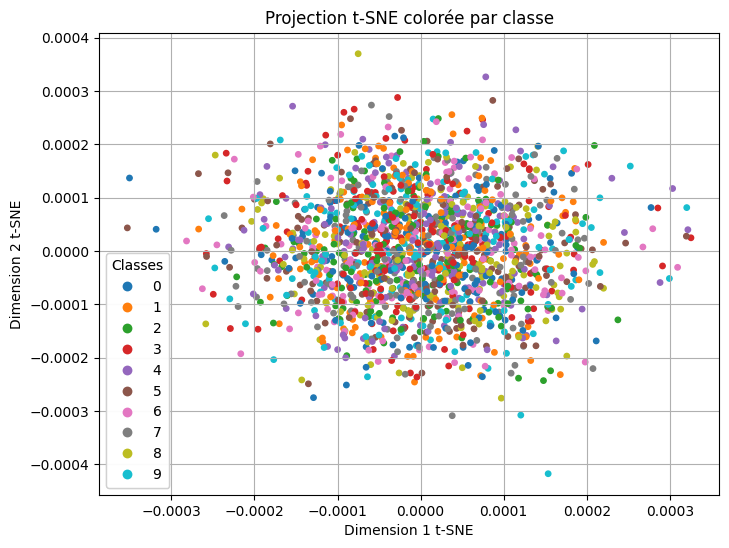

In [111]:


plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y_opt[:, 0], Y_opt[:, 1], c=y, cmap='tab10', s=15)
plt.title("Projection t-SNE colorée par classe")
plt.xlabel("Dimension 1 t-SNE")
plt.ylabel("Dimension 2 t-SNE")
plt.grid(True)

# Légende automatique pour classes
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

plt.show()
